<a href="https://colab.research.google.com/github/anejung/fluorescent-protein/blob/main/visual_phylogenetic_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install biopython
!apt-get install -y clustalo


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clustalo is already the newest version (1.2.4-7).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [9]:
from google.colab import files
uploaded = files.upload()



Saving fluorescent_proteins.fasta to fluorescent_proteins.fasta


In [10]:
!ls -l fluorescent_proteins.fasta


-rw-r--r-- 1 root root 1234 Jul 27 16:38 fluorescent_proteins.fasta


In [11]:
from Bio.Align.Applications import ClustalOmegaCommandline

in_file = "fluorescent_proteins.fasta"
aligned_file = "aligned.aln"

clustalomega_cline = ClustalOmegaCommandline(infile=in_file, outfile=aligned_file, verbose=True, auto=True, outfmt="clustal")
stdout, stderr = clustalomega_cline()

print("Alignment finished.")


Alignment finished.


In [12]:
from Bio import AlignIO

alignment = AlignIO.read(aligned_file, "clustal")
print(alignment)
print(f"Number of sequences aligned: {len(alignment)}")


Alignment with 5 rows and 241 columns
MVSKGEELFTGVVPILVELDGD--VNGHKFSVSGEGEGDATYGK...LYK EGFP
MVSKGEELFTGVVPILVELDGD--VNGHKFSVRGEGEGDATYGK...LYK EYFP
MVSKGEELFTGVVPILVELDGD--VNGHKFSVRGEGEGDATYGK...LYK Venus
MVSKGEELFTGVVPILVELDGD--VNGHKFSVRGEGEGDATYGK...LYK YPet
-MSKGEELIKENMHMKLYMEGTVDHGAHTFSVRGEGEGDATYGK...LYK phiYFP
Number of sequences aligned: 5


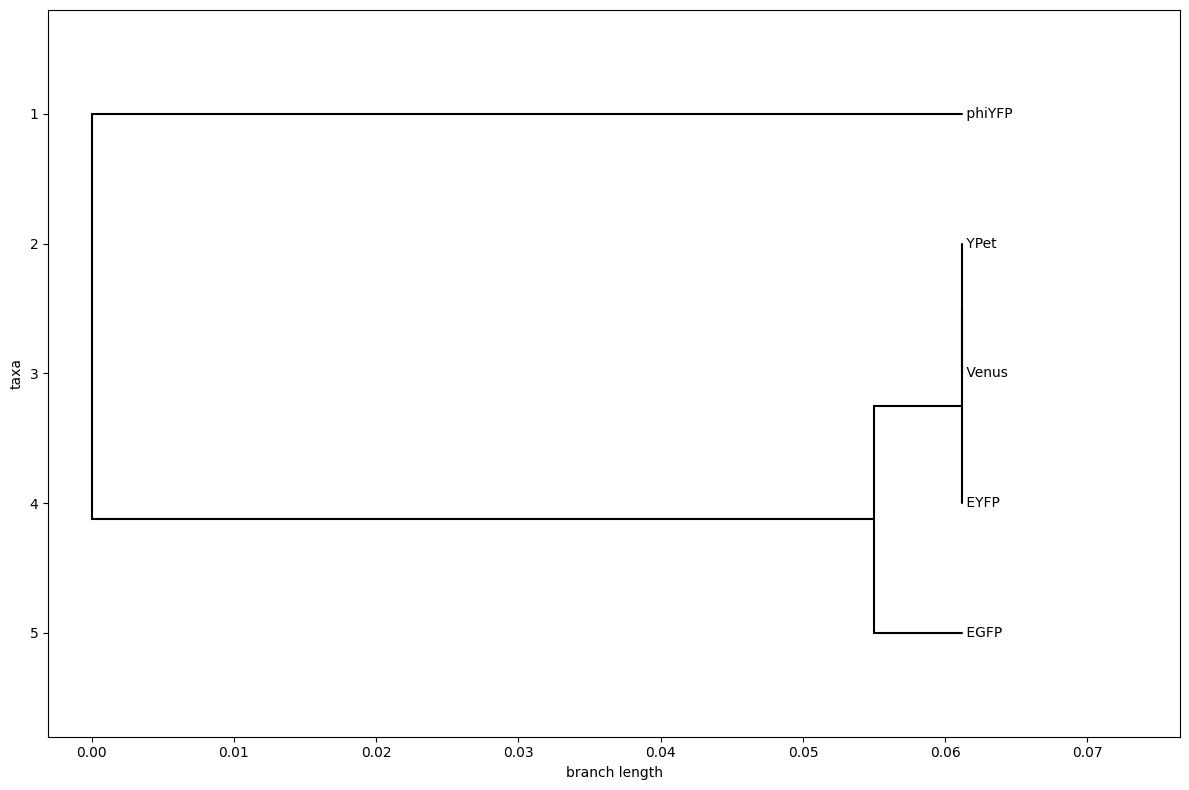

In [22]:
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
import matplotlib.pyplot as plt

calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)


import matplotlib.pyplot as plt
from Bio import Phylo

def draw_tree_readable(tree):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    def label_func(node):
        if node.is_terminal():  # แสดงชื่อเฉพาะ leaf node
            return node.name
        else:
            return None  # ซ่อนชื่อ internal nodes

    Phylo.draw(tree, axes=ax, do_show=False, branch_labels=None, label_func=label_func)
    plt.tight_layout()
    plt.show()

draw_tree_readable(tree)


In [26]:
import numpy as np

def distance_matrix_to_full(dm):
    n = len(dm.names)
    full = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = float(dm[i, j])
            full[i, j] = dist
            full[j, i] = dist
    return full

names = dm.names
distance_matrix = distance_matrix_to_full(dm)
similarity_matrix = 1 - distance_matrix

idx_egfp = names.index("EGFP")
sim_to_egfp = similarity_matrix[idx_egfp]

for name, sim in zip(names, sim_to_egfp):
    print(f"{name} similarity to EGFP: {sim*100:.2f}%")

sorted_sim = sorted([(name, sim) for name, sim in zip(names, sim_to_egfp) if name != "EGFP"],
                    key=lambda x: x[1], reverse=True)

print("\nTop closest proteins to EGFP:")
for name, sim in sorted_sim:
    print(f"{name}: {sim*100:.2f}% similarity")


EGFP similarity to EGFP: 100.00%
EYFP similarity to EGFP: 98.76%
Venus similarity to EGFP: 98.76%
YPet similarity to EGFP: 98.76%
phiYFP similarity to EGFP: 87.55%

Top closest proteins to EGFP:
EYFP: 98.76% similarity
Venus: 98.76% similarity
YPet: 98.76% similarity
phiYFP: 87.55% similarity


In [27]:
import numpy as np

# ฟังก์ชันนี้แปลง DistanceMatrix ของ Biopython ซึ่งเก็บเฉพาะครึ่งบนของเมทริกซ์
# ให้เป็นเมทริกซ์ระยะห่างแบบเต็ม (symmetric matrix) เพื่อใช้งานต่อได้ง่าย
def distance_matrix_to_full(dm):
    n = len(dm.names)  # จำนวนโปรตีนในเมทริกซ์
    full = np.zeros((n, n))  # สร้างเมทริกซ์เต็มขนาด n x n ด้วยศูนย์
    for i in range(n):
        for j in range(i+1, n):
            dist = float(dm[i, j])  # ดึงค่าระยะห่างจากครึ่งบนของเมทริกซ์
            full[i, j] = dist       # กำหนดค่าที่ตำแหน่ง (i, j)
            full[j, i] = dist       # เติมค่าที่ตำแหน่ง (j, i) ให้เมทริกซ์สมมาตร
    return full

names = dm.names  # รายชื่อโปรตีนเรียงตามลำดับในเมทริกซ์

distance_matrix = distance_matrix_to_full(dm)  # แปลง DistanceMatrix เป็นเมทริกซ์เต็ม

# คำนวณ similarity matrix โดยใช้สูตร similarity = 1 - distance
# ซึ่งหมายถึงสัดส่วนของตำแหน่งที่เหมือนกันในการจัดเรียงลำดับ (alignment)
similarity_matrix = 1 - distance_matrix

# หา index ของ EGFP ในรายชื่อโปรตีน
idx_egfp = names.index("EGFP")

# ดึงแถว similarity ของ EGFP กับโปรตีนทุกตัวออกมา
sim_to_egfp = similarity_matrix[idx_egfp]

# แสดงเปอร์เซ็นต์ similarity ระหว่าง EGFP กับโปรตีนแต่ละตัว
for name, sim in zip(names, sim_to_egfp):
    print(f"{name} similarity to EGFP: {sim*100:.2f}%")

# เรียงลำดับโปรตีนที่มี similarity สูงที่สุดกับ EGFP โดยไม่รวม EGFP เอง
sorted_sim = sorted(
    [(name, sim) for name, sim in zip(names, sim_to_egfp) if name != "EGFP"],
    key=lambda x: x[1],
    reverse=True
)

print("\nTop closest proteins to EGFP:")
for name, sim in sorted_sim:
    print(f"{name}: {sim*100:.2f}% similarity")


EGFP similarity to EGFP: 100.00%
EYFP similarity to EGFP: 98.76%
Venus similarity to EGFP: 98.76%
YPet similarity to EGFP: 98.76%
phiYFP similarity to EGFP: 87.55%

Top closest proteins to EGFP:
EYFP: 98.76% similarity
Venus: 98.76% similarity
YPet: 98.76% similarity
phiYFP: 87.55% similarity
